In [18]:
#Import packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from glob import glob
import drpy


import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patheffects as PathEffects
import cartopy.io.shapereader as shpreader
import pandas as pd 
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects
from drpy.graph import colormaps_drpy as cmaps

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [77]:
def centers_to_edges_2d(x):
    """ 
    Create a (N+1, M+1) array of edge locations from a
    (N, M) array of grid center locations.
    
    In the interior, the edge positions set to the midpoints
    of the values in x. For the outermost edges, half the 
    closest dx is assumed to apply. This matters for polar
    meshes, where one edge of the grid becomes a point at the
    polar coordinate origin; dx/2 is a half-hearted way of
    trying to prevent negative ranges.
    
    Useful when plotting with pcolor, which requires
    X, Y of shape (N+1) and grid center values of shape (N).
    Otherwise, pcolor silently discards the last row and column
    of grid center values.
    
    Parameters
    ----------
    x : array, shape (N,M)
        Locations of the centers 
    
    Returns
    -------
    xedge : array, shape (N+1,M+1)
    
    """
    xedge = np.zeros((x.shape[0]+1,x.shape[1]+1))
    # interior is a simple average of four adjacent centers
    xedge[1:-1,1:-1] = (x[:-1,:-1] + x[:-1,1:] + x[1:,:-1] + x[1:,1:])/4.0
    
    #         /\
    #        /\/\
    #       / /\ \
    #      /\/  \/\
    #     / /\  /\ \
    #    /\/  \/  \/\
    #   / /\  /\  /\ \
    #  /\/  \/  \/  \/\
    #4 \/\  /\  /\  /\/ 4
    # 3 \ \/  \/  \/ / 3 
    #    \/\  /\  /\/
    #   2 \ \/  \/ / 2  
    #      \/\  /\/
    #     1 \ \/ / 1
    #        \/\/
    #       0 \/ 0 = center ID of 0th dimension
    #
    
    # calculate the deltas along each edge, excluding corners
    xedge[1:-1,0] = xedge[1:-1, 1] - (xedge[1:-1, 2] - xedge[1:-1, 1])/2.0
    xedge[1:-1,-1]= xedge[1:-1,-2] - (xedge[1:-1,-3] - xedge[1:-1,-2])/2.0
    xedge[0,1:-1] = xedge[1,1:-1]  - (xedge[2,1:-1]  - xedge[1,1:-1])/2.0 
    xedge[-1,1:-1]= xedge[-2,1:-1] - (xedge[-3,1:-1] - xedge[-2,1:-1])/2.0
    
    # now do the corners
    xedge[0,0]  = xedge[1, 1] - (xedge[2, 2] - xedge[1, 1])/2.0
    xedge[0,-1] = xedge[1,-2] - (xedge[2,-3] - xedge[1,-2])/2.0
    xedge[-1,0] = xedge[-2,1] - (xedge[-3,2] - xedge[-2,1])/2.0 
    xedge[-1,-1]= xedge[-2,-2]- (xedge[-3,-3]- xedge[-2,-2])/2.0
    
    return xedge

In [80]:
#Read in GLM data, including the lat/lon information for parallax correction
glm_lla = xr.open_dataset('glm_lla_20230621.nc')


In [83]:
glm_lla['latitude'].shape

(40, 41)

In [84]:
lon_ltg_edge = centers_to_edges_2d(glm_lla['longitude'].values)
lat_ltg_edge = centers_to_edges_2d(glm_lla['latitude'].values)

In [24]:
#Read in radar data, using the nearest file to the GPM timestamp: 23:56
# radar_data = xr.open_dataset("KGRK20230621_235829_V06_grid.nc")
radar_data = pyart.io.read_grid("KGRK20230621_235829_V06_grid.nc")
radar_data = radar_data.to_xarray()
max_refl = radar_data['reflectivity'].max(axis=1)

In [25]:
max_refl

<xarray.DataArray 'reflectivity' (time: 1, y: 1001, x: 1001)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2023-06-21 23:58:29.315000
    lat      (y, x) float64 28.45 28.45 28.45 28.45 ... 32.94 32.94 32.94 32.94
    lon      (y, x) float64 -99.94 -99.93 -99.93 -99.92 ... -94.71 -94.71 -94.7
  * y        (y) float64 -2.5e+05 -2.495e+05 -2.49e+05 ... 2.495e+05 2.5e+05
  * x        (x) float64 -2.5e+05 -2.495e+05 -2.49e+05 ... 2.495e+05 2.5e+05

In [4]:
GPM_file = "2A.GPM.DPR.V9-20211125.20230621-S225600-E002832.052914.V07A.HDF5"
dpr = drpy.core.GPMDPR(GPM_file)#filename=io.filename[0][-64:])
dpr.ds
center_lat = 30.8
center_lon = -96
lon = dpr.ds.Longitude.data.mean()
lat = dpr.ds.Latitude.data.mean()

<xarray.Dataset>
Dimensions:                    (nscan: 7932, nrayNS: 49, nfreq: 2, nbin: 176,
                                nNUBF: 3, nNP: 4, method: 2, foreBack: 6,
                                nearFar: 3, nsdew: 2, nfreqHI: 3, nbinSZP: 7)
Coordinates:
    Latitude                   (nscan, nrayNS) float32 ...
    Longitude                  (nscan, nrayNS) float32 ...
    height                     (nscan, nrayNS, nbin) float32 ...
    time                       (nscan, nrayNS) datetime64[ns] 2023-06-21T22:5...
Dimensions without coordinates: nscan, nrayNS, nfreq, nbin, nNUBF, nNP, method,
                                foreBack, nearFar, nsdew, nfreqHI, nbinSZP
Data variables: (12/96)
    sunLocalTime               (nscan, nrayNS) float32 ...
    elevation                  (nscan, nrayNS) float32 ...
    landSurfaceType            (nscan, nrayNS) int32 ...
    localZenithAngle           (nscan, nrayNS, nfreq) float32 ...
    flagPrecip                 (nscan, nrayNS) int32 ...
    flagSigmaZeroSaturation    (nscan, nrayNS, nfreq) uint8 ...
    ...                         ...
    surfaceSnowfallIndex       (nscan, nrayNS) float32 ...
    flagEcho                   (nscan, nrayNS, nbin) int8 ...
    qualityData                (nscan, nrayNS) int32 ...
    qualityFlag                (nscan, nrayNS, nfreq) int8 ...
    flagSensor                 (nscan, nfreq) int8 ...
    flagScanPattern            (nscan, nfreq) int16 ...
Attributes:
    FS_SwathHeader:  NumberScansInSet=1;\nMaximumNumberScansTotal=10000;\nNum...

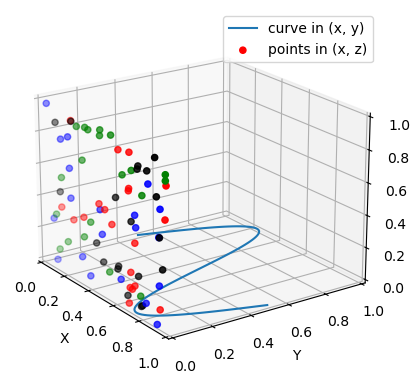

In [7]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.plot(x, y, zs=0, zdir='z', label='curve in (x, y)')

# Plot scatterplot data (20 2D points per colour) on the x and z axes.
colors = ('r', 'g', 'b', 'k')

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.random.sample(20 * len(colors))
y = np.random.sample(20 * len(colors))
c_list = []
for c in colors:
    c_list.extend([c] * 20)
# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x, y) points are plotted on the x and z axes.
ax.scatter(x, y, zs=0, zdir='y', c=c_list, label='points in (x, z)')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0)

plt.show()

In [115]:
params = {'z_vmin':10,'z_vmax':40,'y_max':10,'dfr_vmin':-2,'dfr_vmax':10,
        'dm_vmin':0,'dm_vmax':2,'nw_vmin':1,'nw_vmax':6,'r_vmin':-1,'r_vmax':2,
        'xsections':[0,2,4],'temperature':False,'t_levels':np.linspace(-20,20,10)}

 #determine map center
s = 0 
e = dpr.ds.Longitude.shape[0]
middle = int((e-s)/2)
lon0 = dpr.ds.Longitude.values[middle,24]
lat0 = dpr.ds.Latitude.values[middle,24]
#set specific aspect for cartopy plot
x = 7.5
y = 0.6666666*x
#set corners 
corners = [lon0-x,lon0+x,lat0-y,lat0+y]
start_index=90
end_index=160
scan = 18
s = start_index
e = end_index
w = scan

dpr.get_physcial_distance(reference_point=[dpr.ds.Longitude.values[s,w],dpr.ds.Latitude.values[s,w]])
x = dpr.ds.zFactorMeasured[:,:,:,0].where(dpr.ds.zFactorMeasured[:,:,:,0] >= 10)
cmap = 'Spectral_r'
levels=np.linspace(params['z_vmin'], params['z_vmax'], 50)
vmin = params['z_vmin']
vmax = params['z_vmax']
label = 'KuPR'

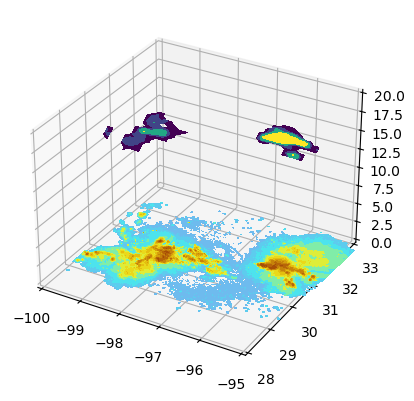

In [163]:
ax = plt.figure().add_subplot(projection='3d')
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
refl = ax.contourf(max_refl['lon'],max_refl['lat'], max_refl[0,:,:],zdir='z', offset=0, cmap='pyart_LangRainbow12',extend = 'max',levels=ref_levels,origin = 'lower', vmin=-24, vmax=72)


# glm = ax.pcolormesh(lon_ltg_edge, lat_ltg_edge, np.log10(glm_data.flash_extent_density))#,offset = 16,vmin=0, vmax=1.0)
glm = ax.contourf(glm_lla['longitude'], glm_lla['latitude'], np.log10(glm_data.flash_extent_density),zdir='z', offset=17,vmin=0, vmax=1.0)

# pm = ax.scatter(dpr.ds.Longitude.values[s:e,w],dpr.ds.Latitude.values[s:e,w],c=dpr.ds.zFactorFinalNearSurface[s:e,w,0].T,vmin=params['z_vmin'],vmax=params['z_vmax'],s=1,cmap='Spectral_r',linewidths=0.1,zorder=10)
pm = ax.contourf(dpr.ds.distance.values[s:e,w],dpr.ds.height.values[s,w,:]/1000,x.values[s:e,w,:].T, offset=0,zdir='z',cmap='Spectral_r',vmin=vmin,vmax=vmax,levels=levels)
# pm = ax.pcolormesh(dpr.ds.distance.values[s:e,w],dpr.ds.height.values[s,w,:]/1000,x.values[s:e,w,:].T,cmap=cmap,vmin=vmin,vmax=vmax)#,levels=levels)

# dpr.ds.height.values[s,w,:]/1000,
ax.set_xlim(-100, -95)
ax.set_ylim(28, 33)
ax.set_zlim(0, 20)
# ax.view_init(elev=20., azim=-35, roll=0)
plt.show()